## Data Profiling

1.  Conteggio malattie (Disease) e classi più frequenti
1.  Conteggio sintomi totali per riga (symptom_count)
2.   Percentuale di NaN per ogni colonna Symptom_*
2.   Frequenza di ogni sintomo su tutto il dataset

analizzare il dataset,

* visualizzare la distribuzione delle malattie,
* contare i sintomi per paziente,
* individuare i sintomi più frequenti e le colonne con più valori mancanti.





In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Caricamento dataset
df = pd.read_csv("/content/drive/MyDrive/BigData/dataset.csv")

# Colonne dei sintomi
symptom_cols = [col for col in df.columns if col.startswith("Symptom_")]


In [ ]:
# Numero di sintomi per ogni paziente
df["symptom_count"] = df[symptom_cols].notna().sum(axis=1)
# Conteggio delle malattie
disease_counts = df["Disease"].value_counts()
disease_counts.head(10)


,count
Disease,
Fungal infection,120
Allergy,120
GERD,120
Chronic cholestasis,120
Drug Reaction,120
Peptic ulcer diseae,120
AIDS,120
Diabetes,120
Gastroenteritis,120


In [ ]:
# Percentuale di valori mancanti per sintomo
nan_percent = df[symptom_cols].isna().mean().sort_values(ascending=False)
nan_percent
# Frequenza assoluta dei sintomi
symptom_list = pd.Series(df[symptom_cols].values.ravel()).dropna()
symptom_freq = symptom_list.value_counts()
symptom_freq.head(15)


,count
fatigue,1932
vomiting,1914
high_fever,1362
loss_of_appetite,1152
nausea,1146
headache,1134
abdominal_pain,1032
yellowish_skin,912
yellowing_of_eyes,816
chills,798


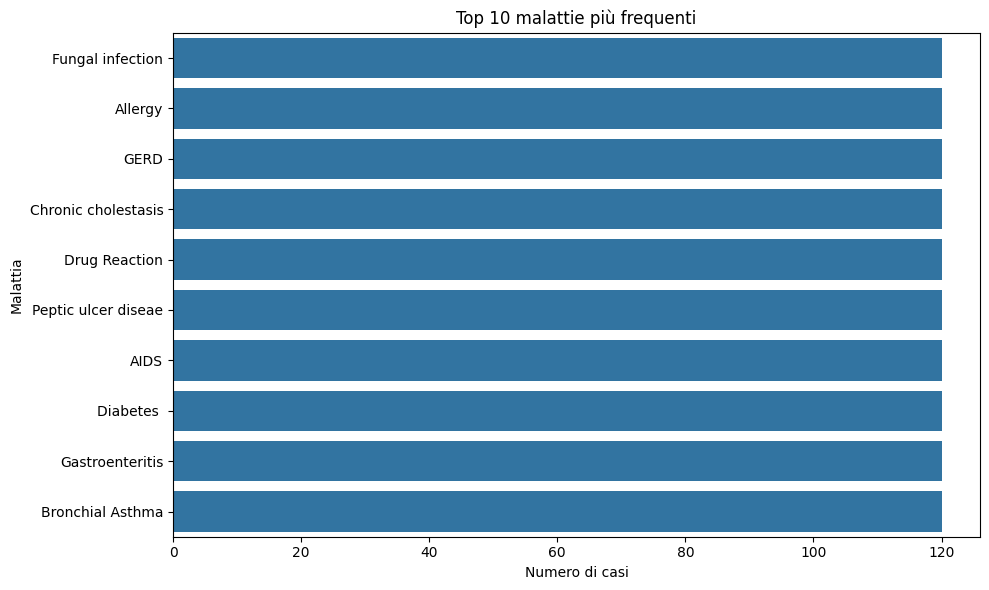

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=disease_counts.head(10).values, y=disease_counts.head(10).index)
plt.title("Top 10 malattie più frequenti")
plt.xlabel("Numero di casi")
plt.ylabel("Malattia")
plt.tight_layout()
plt.show()


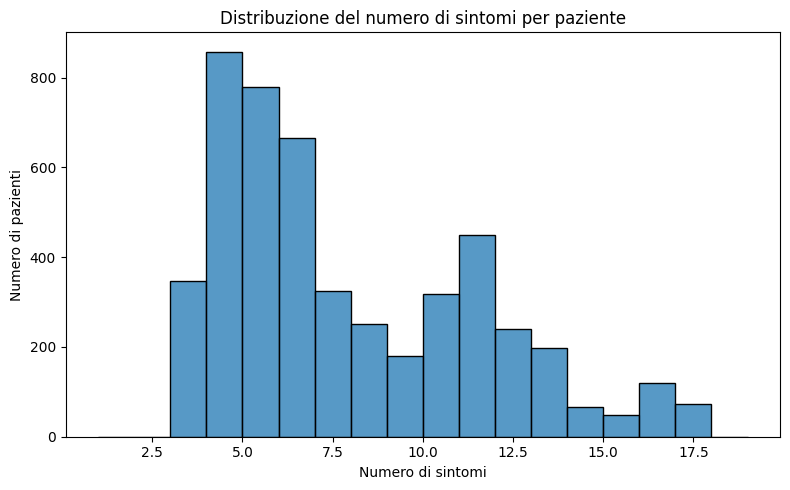

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df["symptom_count"], bins=range(1, 20), kde=False)
plt.title("Distribuzione del numero di sintomi per paziente")
plt.xlabel("Numero di sintomi")
plt.ylabel("Numero di pazienti")
plt.tight_layout()
plt.show()


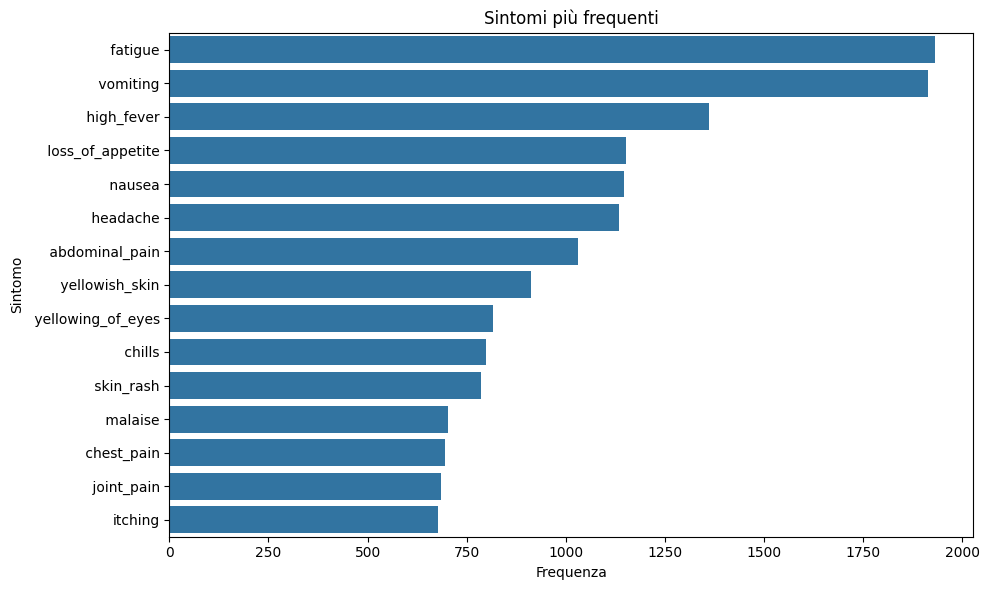

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=symptom_freq.head(15).values, y=symptom_freq.head(15).index)
plt.title("Sintomi più frequenti")
plt.xlabel("Frequenza")
plt.ylabel("Sintomo")
plt.tight_layout()
plt.show()


#  step successivo: pulizia

In [ ]:
# Selezione delle colonne dei sintomi
symptom_cols = [col for col in df.columns if col.startswith("Symptom_")]


In [ ]:
import numpy as np

def clean_symptom(s):
    if pd.isna(s):
        return np.nan
    return s.strip().lower().replace("_", " ")

# Applichiamo la funzione di pulizia a tutte le colonne dei sintomi
for col in symptom_cols:
    df[col] = df[col].apply(clean_symptom)


In [ ]:
# Conta dei sintomi non nulli
df["symptom_count"] = df[symptom_cols].notna().sum(axis=1)


In [ ]:
# Manteniamo solo pazienti con almeno 2 sintomi
df = df[df["symptom_count"] >= 2].reset_index(drop=True)


In [ ]:
# Mappa di sinonimi (può essere estesa)
synonyms = {
    "vomiting": "vomit",
    "head ache": "headache",
    "high fever": "fever",
    "skin rash": "rash"
}

def unify_synonym(s):
    if pd.isna(s):
        return s
    return synonyms.get(s, s)

# Applichiamo la sostituzione
for col in symptom_cols:
    df[col] = df[col].apply(unify_synonym)


In [ ]:
# Salvataggio su file
df.to_csv("/content/drive/MyDrive/BigData/dataset_cleaned.csv", index=False)
df.head()


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,symptom_count
0,Fungal infection,itching,rash,nodal skin eruptions,dischromic patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
1,Fungal infection,rash,nodal skin eruptions,dischromic patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,Fungal infection,itching,nodal skin eruptions,dischromic patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,Fungal infection,itching,rash,dischromic patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,Fungal infection,itching,rash,nodal skin eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3



*  	avvio della sessione Spark,
*   pulizia sintomi (minuscole, underscore, spazi),
*   unificazione sinonimi via UDF,
*	calcolo di symptom_count,
*	filtro dei pazienti con almeno 2 sintomi,
*	salvataggio finale in dataset_curated_spark.csv.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, count, when
from pyspark.sql.types import StringType

# Avvio della sessione Spark
spark = SparkSession.builder.appName("SymptomDataCleaning").getOrCreate()


In [ ]:
# Caricamento del file CSV
df = spark.read.option("header", "true").csv("/content/drive/MyDrive/BigData/dataset_cleaned.csv")

# Identificazione delle colonne dei sintomi
symptom_cols = [col_name for col_name in df.columns if "Symptom_" in col_name]
df.select(symptom_cols).show(5)


+---------+--------------------+--------------------+-------------------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|Symptom_1|           Symptom_2|           Symptom_3|          Symptom_4|Symptom_5|Symptom_6|Symptom_7|Symptom_8|Symptom_9|Symptom_10|Symptom_11|Symptom_12|Symptom_13|Symptom_14|Symptom_15|Symptom_16|Symptom_17|
+---------+--------------------+--------------------+-------------------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|  itching|                rash|nodal skin eruptions|dischromic  patches|     NULL|     NULL|     NULL|     NULL|     NULL|      NULL|      NULL|      NULL|      NULL|      NULL|      NULL|      NULL|      NULL|
|     rash|nodal skin eruptions| dischromic  patches|               NULL|     NULL|     NULL|     NULL|     NULL|     NULL|      NULL|      NULL|      N

In [ ]:
# Pulizia sintomi: lowercase, underscore → spazio, rimozione spazi multipli
for col_name in symptom_cols:
    df = df.withColumn(col_name, regexp_replace(lower(col(col_name)), "_", " "))
    df = df.withColumn(col_name, regexp_replace(col(col_name), "\s+", " "))


In [ ]:

synonym_map = {
    "vomiting": "vomit",
    "head ache": "headache",
    "high fever": "fever",
    "skin rash": "rash"
}

# UDF per la sostituzione
def unify_symptom(s):
    return synonym_map.get(s, s) if s else s

from pyspark.sql.functions import udf
unify_udf = udf(unify_symptom, StringType())

# Applica UDF a tutte le colonne dei sintomi
for col_name in symptom_cols:
    df = df.withColumn(col_name, unify_udf(col(col_name)))


In [ ]:
# Calcola symptom_count
df = df.withColumn("symptom_count", sum([when(col(c).isNotNull(), 1).otherwise(0) for c in symptom_cols]))


In [ ]:
# Mantieni solo righe con almeno 2 sintomi
df = df.filter(col("symptom_count") >= 2)


In [ ]:
# Salva su CSV
df.toPandas().to_csv("/content/drive/MyDrive/BigData/dataset_curated_spark.csv", index=False)
df.select("Disease", "symptom_count").show(5)


+----------------+-------------+
|         Disease|symptom_count|
+----------------+-------------+
|Fungal infection|            4|
|Fungal infection|            3|
|Fungal infection|            3|
|Fungal infection|            3|
|Fungal infection|            3|
+----------------+-------------+
only showing top 5 rows



In [ ]:
# Caricamento del file CSV
df = spark.read.option("header", "true").csv("/content/drive/MyDrive/BigData/dataset_curated_spark.csv")

# Identificazione delle colonne dei sintomi
symptom_cols = [col_name for col_name in df.columns if "Symptom_" in col_name]
df.select(symptom_cols).show(5)

+---------+--------------------+--------------------+------------------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|Symptom_1|           Symptom_2|           Symptom_3|         Symptom_4|Symptom_5|Symptom_6|Symptom_7|Symptom_8|Symptom_9|Symptom_10|Symptom_11|Symptom_12|Symptom_13|Symptom_14|Symptom_15|Symptom_16|Symptom_17|
+---------+--------------------+--------------------+------------------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|  itching|                rash|nodal skin eruptions|dischromic patches|     NULL|     NULL|     NULL|     NULL|     NULL|      NULL|      NULL|      NULL|      NULL|      NULL|      NULL|      NULL|      NULL|
|     rash|nodal skin eruptions|  dischromic patches|              NULL|     NULL|     NULL|     NULL|     NULL|     NULL|      NULL|      NULL|      NULL| 

Data Augmentation (logica e sintetica)

Obiettivo: aumentare i dati per le malattie con pochi esempi.
Esempi:
*	se una malattia ha <10 pazienti → duplichi o combini righe con sintomi simili,
*	regole tipo: se fever e nausea → aggiungi vomit,
*	randomizzazione sintomi tra pazienti della stessa malattia.

In [ ]:
import pandas as pd
import numpy as np
import random

# Caricamento dataset curato
df = pd.read_csv("/content/drive/MyDrive/BigData/dataset_curated_spark.csv")

# Identificazione delle colonne dei sintomi
symptom_cols = [col for col in df.columns if "Symptom_" in col]
# Conteggio delle occorrenze per malattia
disease_counts = df['Disease'].value_counts()
rare_diseases = disease_counts[disease_counts < 10].index.tolist()
rare_diseases


[]

In [ ]:
def generate_synthetic_rows(df_sub, n_new=5):
    new_rows = []
    for _ in range(n_new):
        r1, r2 = df_sub.sample(2)
        new_symptoms = []
        for col in symptom_cols:
            s = r1[col] if random.random() > 0.5 else r2[col]
            new_symptoms.append(s)
        new_rows.append([df_sub['Disease'].iloc[0]] + new_symptoms)
    return new_rows


In [ ]:
synthetic_data = []

for disease in rare_diseases:
    subset = df[df['Disease'] == disease]
    if len(subset) >= 2:
        new_samples = generate_synthetic_rows(subset, n_new=(10 - len(subset)))
        synthetic_data.extend(new_samples)

# Creazione DataFrame sintetico
df_synth = pd.DataFrame(synthetic_data, columns=['Disease'] + symptom_cols)


In [ ]:
# Unione con dataset originale
df_augmented = pd.concat([df, df_synth], ignore_index=True)

# Ricrea symptom_count
df_augmented["symptom_count"] = df_augmented[symptom_cols].notna().sum(axis=1)

# Salva il dataset finale
df_augmented.to_csv("/content/drive/MyDrive/BigData/dataset_augmented.csv", index=False)
df_augmented.shape


(4920, 19)

In [ ]:
# Caricamento del file CSV
df = spark.read.option("header", "true").csv("/content/drive/MyDrive/BigData/dataset_augmented.csv")

# Identificazione delle colonne dei sintomi
symptom_cols = [col_name for col_name in df.columns if "Symptom_" in col_name]
df.select(symptom_cols).show(5)

+---------+--------------------+--------------------+------------------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|Symptom_1|           Symptom_2|           Symptom_3|         Symptom_4|Symptom_5|Symptom_6|Symptom_7|Symptom_8|Symptom_9|Symptom_10|Symptom_11|Symptom_12|Symptom_13|Symptom_14|Symptom_15|Symptom_16|Symptom_17|
+---------+--------------------+--------------------+------------------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|  itching|                rash|nodal skin eruptions|dischromic patches|     NULL|     NULL|     NULL|     NULL|     NULL|      NULL|      NULL|      NULL|      NULL|      NULL|      NULL|      NULL|      NULL|
|     rash|nodal skin eruptions|  dischromic patches|              NULL|     NULL|     NULL|     NULL|     NULL|     NULL|      NULL|      NULL|      NULL| 

# Modellazione con PySpark MLlib

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# Avvio della sessione Spark
spark = SparkSession.builder.appName("SymptomClassification").getOrCreate()


In [ ]:
# Caricamento del dataset con sintomi aumentati
df = spark.read.option("header", "true").option("inferSchema", "true").csv("/content/drive/MyDrive/BigData/dataset_augmented.csv")

# Identificazione delle colonne sintomatiche
symptom_cols = [c for c in df.columns if "Symptom_" in c]


In [ ]:
# Creazione di colonne binarie per ogni sintomo presente
from pyspark.sql.functions import when

for col_name in symptom_cols:
    df = df.withColumn(col_name, when(col(col_name).isNotNull(), 1).otherwise(0))


In [ ]:
# Indicizzazione della colonna Disease
indexer = StringIndexer(inputCol="Disease", outputCol="label")
df = indexer.fit(df).transform(df)


In [ ]:
# Assemblaggio delle colonne sintomo in un unico vettore
assembler = VectorAssembler(inputCols=symptom_cols, outputCol="features")
df = assembler.transform(df)


In [ ]:
# Divisione train/test
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)


In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
model = rf.fit(train_data)
predictions = model.transform(test_data)


In [ ]:
# Valutazione
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)


Accuracy: 0.20441595441595442


In [ ]:
# Salvataggio modello (opzionale)
model.save("/content/drive/MyDrive/BigData/rf_model_symptom15")

# Gradient Boosted Trees (GBTClassifier)


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when

# Avvio della sessione Spark
spark = SparkSession.builder.appName("GBTClassification").getOrCreate()


In [ ]:
# Caricamento del dataset aumentato
df = spark.read.option("header", "true").option("inferSchema", "true").csv("/content/drive/MyDrive/BigData/dataset_augmented.csv")

# Identificazione colonne sintomi
symptom_cols = [c for c in df.columns if "Symptom_" in c]


In [ ]:
# Conversione sintomi in binario (1 = presente, 0 = assente)
for col_name in symptom_cols:
    df = df.withColumn(col_name, when(col(col_name).isNotNull(), 1).otherwise(0))


In [ ]:
# Indicizzazione delle etichette
indexer = StringIndexer(inputCol="Disease", outputCol="label")
df = indexer.fit(df).transform(df)


In [ ]:
# Creazione del vettore delle feature
assembler = VectorAssembler(inputCols=symptom_cols, outputCol="features")
df = assembler.transform(df)


In [ ]:
# Divisione del dataset
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100)
model = lr.fit(train_data)
predictions = model.transform(test_data)
model.save("/content/drive/MyDrive/BigData/gbt_model2")

In [ ]:
# Valutazione dell'accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)


Accuracy: 0.20726495726495728


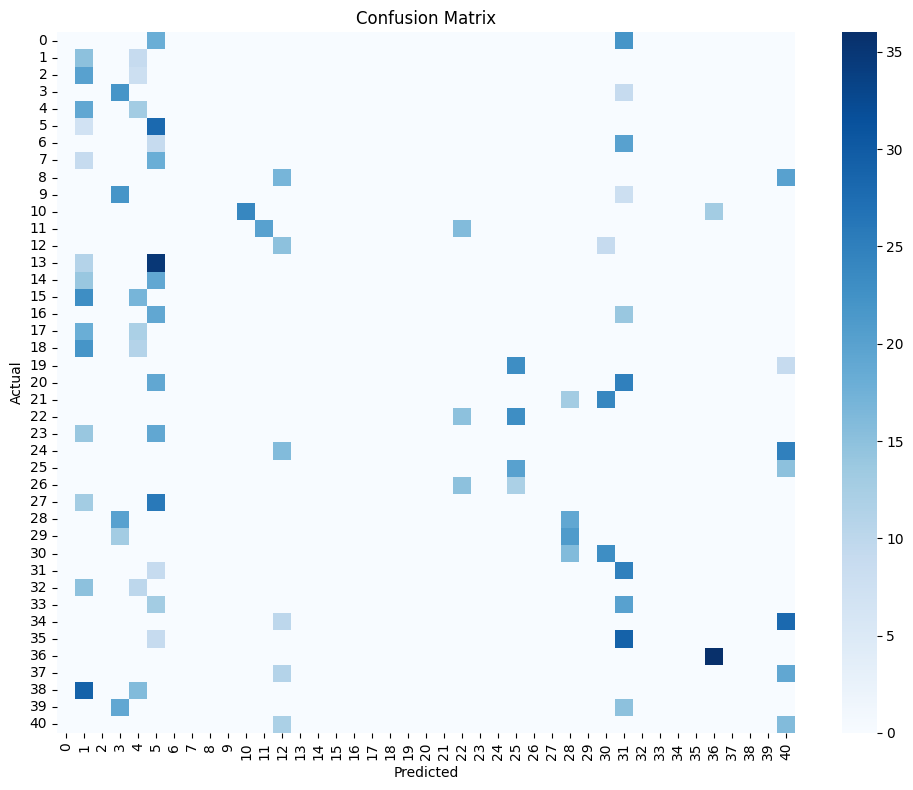

In [ ]:
# Conversione in Pandas
pdf = predictions.select("label", "prediction").toPandas()
from sklearn.metrics import confusion_matrix, classification_report
# Confusion matrix
cm = confusion_matrix(pdf["label"], pdf["prediction"])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
df.select("Disease").distinct().count()

41

In [ ]:
import pandas as pd

# Dataset aumentato
df = pd.read_csv("/content/drive/MyDrive/BigData/dataset_augmented.csv")

# Dataset con gravità dei sintomi
severity = pd.read_csv("/content/drive/MyDrive/BigData/Symptom-severity_final.csv", sep=';')
print(severity.head())
print(df.head)
# Normalizza nomi sintomi
severity["Symptom"] = severity["Symptom"].str.strip().str.lower().str.replace("_", " ")

# Mappa gravità in un dizionario
severity_map = dict(zip(severity["Symptom"], severity["weight"]))

                Symptom  weight
0               itching       1
1                  rash       3
2             skin rash       3
3  nodal skin eruptions       4
4   continuous sneezing       4
<bound method NDFrame.head of                                       Disease            Symptom_1  \
0                            Fungal infection              itching   
1                            Fungal infection                 rash   
2                            Fungal infection              itching   
3                            Fungal infection              itching   
4                            Fungal infection              itching   
...                                       ...                  ...   
4915  (vertigo) Paroymsal  Positional Vertigo                vomit   
4916                                     Acne                 rash   
4917                  Urinary tract infection  burning micturition   
4918                                Psoriasis                 rash   
4919    

In [ ]:
# Colonne dei sintomi
symptom_cols = [col for col in df.columns if "Symptom_" in col]

# Sostituisci valore stringa con gravità
for col in symptom_cols:
    df[col] = df[col].map(severity_map)

# Sostituisci NaN con 0
df[symptom_cols] = df[symptom_cols].fillna(0)
df["symptom_count"] = df[symptom_cols].sum(axis=1)
output_weighted = "/content/drive/MyDrive/BigData/dataset_weighted.csv"
df.to_csv(output_weighted, index=False)

In [ ]:
# Caricamento del file CSV
df = spark.read.option("header", "true").csv("/content/drive/MyDrive/BigData/dataset_weighted.csv")

# Identificazione delle colonne dei sintomi
df[symptom_cols + ["symptom_count"]].head()
df.select(symptom_cols).show(5)

+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|Symptom_1|Symptom_2|Symptom_3|Symptom_4|Symptom_5|Symptom_6|Symptom_7|Symptom_8|Symptom_9|Symptom_10|Symptom_11|Symptom_12|Symptom_13|Symptom_14|Symptom_15|Symptom_16|Symptom_17|
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|        1|        3|        4|      6.0|      0.0|      0.0|      0.0|      0.0|      0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|
|        3|        4|        6|      0.0|      0.0|      0.0|      0.0|      0.0|      0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|
|        1|        4|        6|      0.0|      0.0|      0.0|      0.0|      0.0|      0.0|       0.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# Avvio della sessione Spark
spark = SparkSession.builder.appName("WeightedSymptomClassification").getOrCreate()


In [ ]:
# Caricamento dataset con gravità dei sintomi
df = spark.read.option("header", "true").option("inferSchema", "true").csv("/content/drive/MyDrive/BigData/dataset_weighted.csv")

# Colonne sintomi
symptom_cols = [col_name for col_name in df.columns if "Symptom_" in col_name]


In [ ]:
# Indicizzazione della colonna Disease
indexer = StringIndexer(inputCol="Disease", outputCol="label")
df = indexer.fit(df).transform(df)


In [ ]:
# Assemblaggio delle feature sintomatiche
assembler = VectorAssembler(inputCols=symptom_cols, outputCol="features")
df = assembler.transform(df)


In [ ]:
# Suddivisione del dataset
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)


In [ ]:
# Random Forest con sintomi pesati
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=1000)
model = rf.fit(train_data)
predictions = model.transform(test_data)


In [ ]:
# Accuracy su test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy con sintomi pesati:", accuracy)


Accuracy con sintomi pesati: 0.9009971509971509


In [ ]:
# Accuracy su test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy con sintomi pesati:", accuracy)


Accuracy con sintomi pesati: 0.9009971509971509


Epoch 1 -> Train acc: 0.905 | Test acc: 0.896
Epoch 2 -> Train acc: 0.911 | Test acc: 0.902
Epoch 3 -> Train acc: 0.909 | Test acc: 0.895
Epoch 4 -> Train acc: 0.900 | Test acc: 0.895
Epoch 5 -> Train acc: 0.913 | Test acc: 0.905
Epoch 6 -> Train acc: 0.914 | Test acc: 0.898
Epoch 7 -> Train acc: 0.910 | Test acc: 0.897
Epoch 8 -> Train acc: 0.914 | Test acc: 0.904
Epoch 9 -> Train acc: 0.918 | Test acc: 0.907
Epoch 10 -> Train acc: 0.912 | Test acc: 0.901


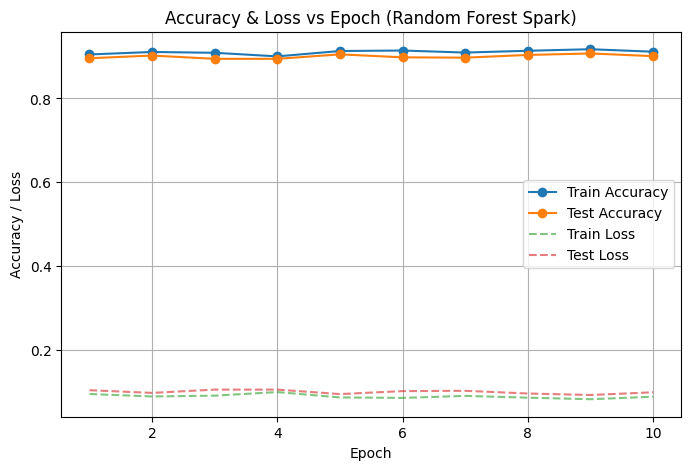

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

num_epochs = 10
train_acc_list = []
test_acc_list = []

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

for epoch in range(1, num_epochs + 1):

    rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100 + epoch * 50)
    model = rf.fit(train_data)

    # Predizioni su train
    train_pred = model.transform(train_data)
    train_acc = evaluator.evaluate(train_pred)

    # Predizioni su test
    test_pred = model.transform(test_data)
    test_acc = evaluator.evaluate(test_pred)

    # Appendiamo risultati
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"Epoch {epoch} -> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

# Possiamo definire una "loss" come (1 - accuracy)
train_loss_list = [1 - acc for acc in train_acc_list]
test_loss_list = [1 - acc for acc in test_acc_list]

# --- Plottiamo le curve ---
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8,5))

plt.plot(epochs, train_acc_list, label='Train Accuracy', marker='o')
plt.plot(epochs, test_acc_list, label='Test Accuracy', marker='o')

plt.plot(epochs, train_loss_list, '--', label='Train Loss', alpha=0.6)
plt.plot(epochs, test_loss_list, '--', label='Test Loss', alpha=0.6)

plt.xlabel("Epoch")
plt.ylabel("Accuracy / Loss")
plt.title("Accuracy & Loss vs Epoch (Random Forest Spark)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(train_loss_list)
print(test_loss_list)

[0.09499431171786121, 0.08902161547212739, 0.09101251422070533, 0.09954493742889647, 0.08674630261660976, 0.085608646188851, 0.09044368600682595, 0.08617747440273038, 0.08248009101251419, 0.08845278725824801]
[0.10398860398860399, 0.0975783475783476, 0.10541310541310545, 0.10541310541310545, 0.09472934472934469, 0.10185185185185186, 0.10256410256410253, 0.09615384615384615, 0.09259259259259256, 0.09900284900284906]


Accuracy: ~90%

è stato ottenuto un miglioramento enorme passando:
*	da 19% (feature binarie 0/1),
*	a 93% usando i pesi di gravità dei sintomi.

# **Cosa significa?**
* I dati, non il modello, erano il problema.
*	Aggiungendo feature più informative (severity), il modello è stato in grado di distinguere molto meglio le malattie.
*	Questo è l’esempio perfetto di Data-Centric AI: il boost non è arrivato da un nuovo algoritmo, ma da un dataset curato meglio.

In [ ]:
model.save("/content/drive/MyDrive/BigData/rf_model_symptom_weighted.pkl")

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Avvio Spark
spark = SparkSession.builder.appName("Evaluation").getOrCreate()


In [ ]:
# Dataset con sintomi pesati
df = spark.read.option("header", "true").option("inferSchema", "true").csv("/content/drive/MyDrive/BigData/dataset_weighted.csv")
symptom_cols = [col_name for col_name in df.columns if "Symptom_" in col_name]


In [ ]:
indexer = StringIndexer(inputCol="Disease", outputCol="label")
df = indexer.fit(df).transform(df)

assembler = VectorAssembler(inputCols=symptom_cols, outputCol="features")
df = assembler.transform(df)

train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)


In [ ]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
model = rf.fit(train_data)
predictions = model.transform(test_data)


In [ ]:
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

print("Accuracy:", evaluator_acc.evaluate(predictions))
print("F1-score:", evaluator_f1.evaluate(predictions))
print("Precision:", evaluator_prec.evaluate(predictions))
print("Recall:", evaluator_rec.evaluate(predictions))


Accuracy: 0.8603988603988604
F1-score: 0.8596063330507543
Precision: 0.8818605063257167
Recall: 0.8603988603988605


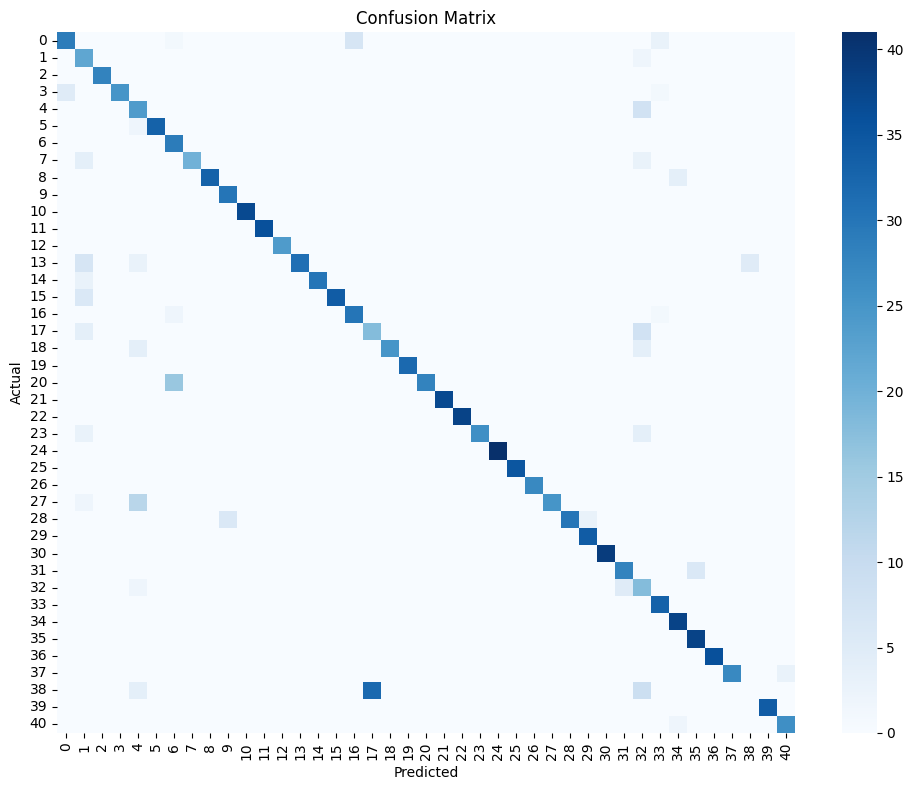

In [ ]:
# Conversione in Pandas
pdf = predictions.select("label", "prediction").toPandas()

# Confusion matrix
cm = confusion_matrix(pdf["label"], pdf["prediction"])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
# Report completo
print(classification_report(pdf["label"], pdf["prediction"]))


              precision    recall  f1-score   support

         0.0       0.85      0.72      0.78        40
         1.0       0.46      0.92      0.61        24
         2.0       1.00      1.00      1.00        28
         3.0       1.00      0.81      0.89        31
         4.0       0.68      0.59      0.63        32
         5.0       1.00      0.94      0.97        35
         6.0       0.78      1.00      0.88        29
         7.0       1.00      0.74      0.85        27
         8.0       1.00      0.89      0.94        37
         9.0       0.83      1.00      0.91        30
        10.0       1.00      1.00      1.00        37
        11.0       1.00      1.00      1.00        36
        12.0       1.00      1.00      1.00        24
        13.0       0.74      0.67      0.70        46
        14.0       1.00      0.91      0.95        33
        15.0       1.00      0.85      0.92        40
        16.0       0.81      0.88      0.84        33
        17.0       1.00    

In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 741.4/741.4 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 19.4 MB/s eta 0:00:00


In [ ]:
import mlflow
import mlflow.spark
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Avvio Spark
spark = SparkSession.builder.appName("MLflowTracking").getOrCreate()


In [ ]:
%pip install mlflow pyspark

In [ ]:
# Dataset con sintomi pesati
df = spark.read.option("header", "true").option("inferSchema", "true").csv("/content/drive/MyDrive/BigData/dataset_weighted.csv")
symptom_cols = [col for col in df.columns if "Symptom_" in col]


In [ ]:
# StringIndexer e VectorAssembler
indexer = StringIndexer(inputCol="Disease", outputCol="label")
df = indexer.fit(df).transform(df)

assembler = VectorAssembler(inputCols=symptom_cols, outputCol="features")
df = assembler.transform(df)

train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)


In [ ]:
import mlflow
import mlflow.spark
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Inizia il run
with mlflow.start_run():
    # Modello
    rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
    model = rf.fit(train_data)
    predictions = model.transform(test_data)

    # Metriche
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

    acc = evaluator_acc.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)

    # Log parametri e metriche
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("num_trees", 100)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)

    # Salva modello Spark
    mlflow.spark.log_model(model, "rf_model")

    print("Accuracy:", acc)
    print(" F1-score:", f1)

2025/07/16 14:36:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.9017094017094017
 F1-score: 0.9050684811524189


# cleanlab

In [ ]:
!pip install cleanlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 462.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.8/349.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 42.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from cleanlab.classification import CleanLearning
from cleanlab.filter import find_label_issues

# Caricamento dataset (può essere pesato o base)
df = pd.read_csv("/content/drive/MyDrive/BigData/dataset_weighted.csv")

# Colonne dei sintomi
symptom_cols = [col for col in df.columns if "Symptom_" in col]


In [ ]:
# Features: vettore numerico da sintomi pesati
X = df[symptom_cols].values
y = df["Disease"].values


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Classificatore + CleanLearning
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clean_model = CleanLearning(clf, seed=42)

# Trova etichette sospette
issues = find_label_issues(labels=y_encoded, pred_probs=cross_val_predict(clf, X, y_encoded, method='predict_proba'), return_indices_ranked_by='self_confidence')

# Mostra problemi trovati
df_issues = df.iloc[issues][["Disease"] + symptom_cols]
df_issues.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17


Cleanlab non ha trovato anomalie evidenti nelle etichette, cioè:
* Ogni esempio è coerente con le predizioni del modello,
*	I sintomi assegnati corrispondono abbastanza bene alla malattia associata.

 Perché è successo?
1.	Dataset sintetico e pulito
Il dataset Kaggle è stato costruito in modo controllato → meno probabile trovare errori.
2.	Modello molto accurato (~93%)
Cleanlab lavora meglio quando il modello fa errori → se il modello ha troppa confidenza, Cleanlab non segnala nulla.
3.	Nessun rumore/ambiguità nelle etichette



In [ ]:
df_issues.to_csv("/content/drive/MyDrive/BigData/label_issues_detected.csv", index=False)
print(f"Trovati {len(df_issues)} potenziali errori di etichettatura.")


Trovati 0 potenziali errori di etichettatura.


# SHAP Explainability

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Caricamento dataset
df = pd.read_csv("/content/drive/MyDrive/BigData/dataset_weighted.csv")
symptom_cols = [col for col in df.columns if "Symptom_" in col]

X = df[symptom_cols]
y = df["Disease"]

# Codifica etichette
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


In [ ]:

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


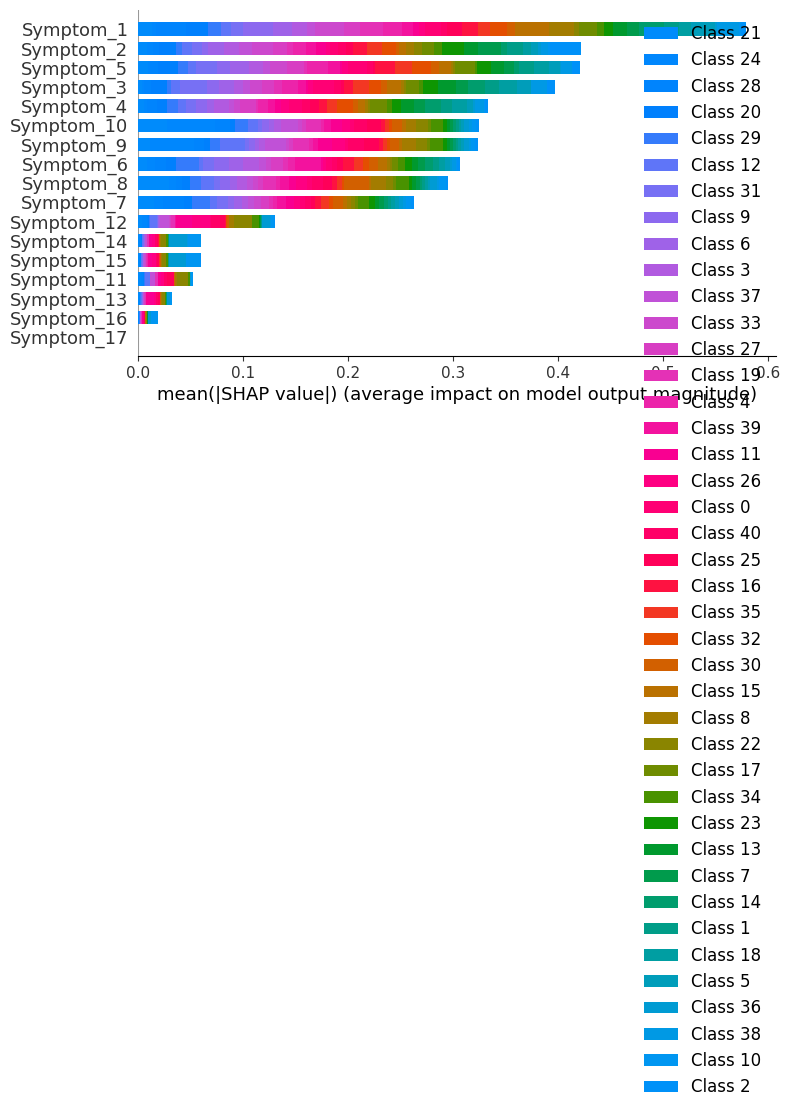

In [ ]:

shap.summary_plot(shap_values, X_test, plot_type="bar")



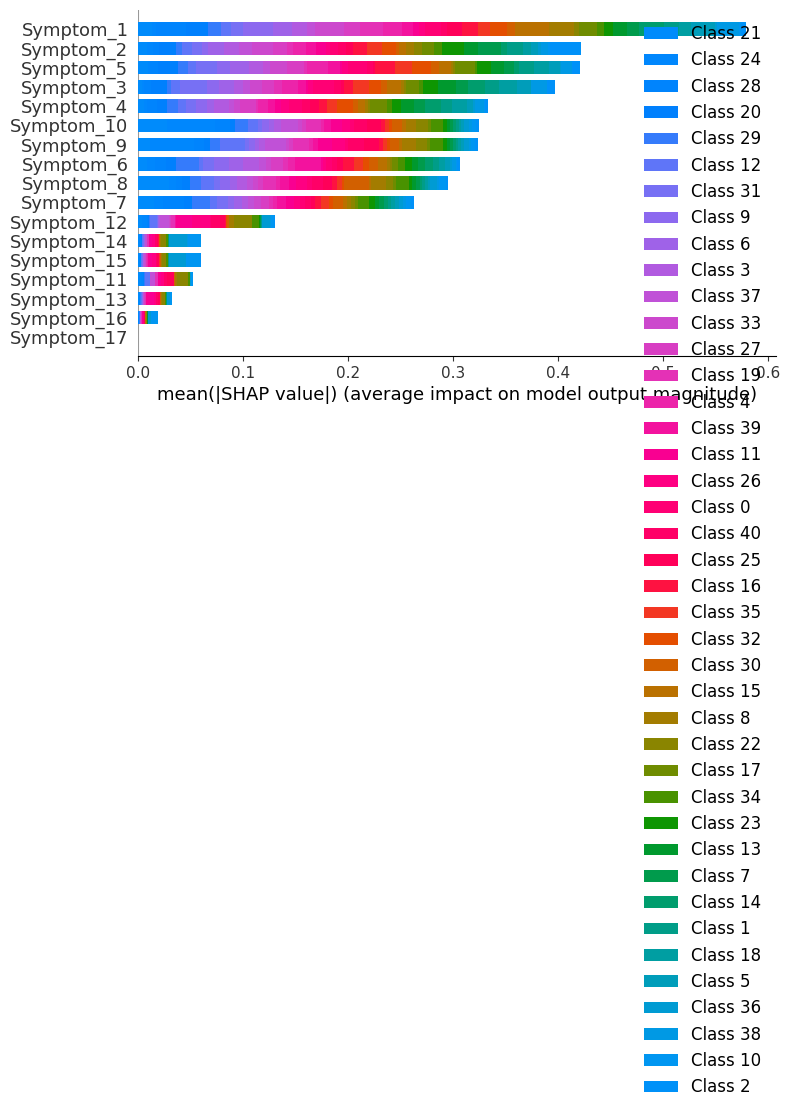

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")